# Insurance Fraud Detection Model

In [1]:
# ---------------------------------------
# Library Imports (duplicates removed)
# ---------------------------------------

# ▶ Basic Operations & Visualization
import pandas as pd                    # Data handling
import numpy as np                     # Numerical computation
import matplotlib.pyplot as plt        # Plotting
import shap                            # Feature visualization
import warnings                        # Warning control
warnings.filterwarnings('ignore')      # Suppress warnings

# ▶ Preprocessing
from sklearn.preprocessing import LabelEncoder        # Label encoding
from sklearn.preprocessing import OneHotEncoder       # One-hot encoding
from sklearn.impute import SimpleImputer              # Missing value imputation
from sklearn.utils.class_weight import compute_sample_weight  # Class weighting
from sklearn.model_selection import train_test_split  # Train-test split

# ▶ Models
from sklearn.tree import DecisionTreeClassifier       # Decision Tree
from sklearn.ensemble import RandomForestClassifier   # Random Forest
from xgboost import XGBClassifier                     # XGBoost
import xgboost as xgb                                 # XGBoost main module

# ▶ Evaluation Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, auc,
    f1_score, roc_auc_score, average_precision_score,
    accuracy_score, roc_curve, precision_recall_curve
)

# ▶ Imbalanced Data Handling
from imblearn.over_sampling import SMOTE              # Oversampling


C:\Users\okada\anaconda3\envs\fraud-detect\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Objective and Background
To detect fraudulent activities hidden in insurance claims data, this project aims to prevent overpayments and increased risks, ultimately reducing company costs and improving reliability. This project utilizes machine learning to build a model that identifies fraudulent claims.

## 2. Data Inspection and Preprocessing
Before building the machine learning model, we performed preprocessing steps such as checking for missing values, encoding categorical variables, and removing unnecessary columns. These steps ensured the dataset was properly formatted for modeling.

In [2]:
# Load CSV file
df = pd.read_csv(r'C:\Users\okada\fraud_oracle.csv')

# Display the first few rows of the dataset to check contents
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
# Count and display the number of missing (null) values in each column
print(df.isnull().sum())

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64


In [4]:
# Count the occurrences of each value (0 and 1) in the 'FraudFound_P' column
df['FraudFound_P'].value_counts()

FraudFound_P
0    14497
1      923
Name: count, dtype: int64

In [5]:
# Check the data type of each column (e.g., int, float, object)
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [6]:
# Extract columns with 'object' data type excluding the target variable 
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Display the list of categorical column names  
print("List of categorical columns:")
print(categorical_cols)

List of categorical columns:
['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']


In [7]:
# Remove unnecessary columns 
df = df.drop(['PolicyNumber', 'RepNumber'], axis=1)

# Add 'WeekOfMonth' and 'WeekOfMonthClaimed' to the list of categorical variables if not already included
for col in ['WeekOfMonth', 'WeekOfMonthClaimed']:
    if col not in categorical_cols:
        categorical_cols.append(col)

# Convert categorical variables to string type
df[categorical_cols] = df[categorical_cols].astype(str)

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply encoding to categorical variables
encoded_array = ohe.fit_transform(df[categorical_cols])

# Get feature names after encoding
encoded_cols = ohe.get_feature_names_out(categorical_cols)

# Convert encoded result to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

# Drop original categorical columns and merge with encoded results
df_for_model = df.drop(columns=categorical_cols)
df_for_model = pd.concat([df_for_model, encoded_df], axis=1)

# Display the head of the processed DataFrame to check the result
df_for_model.head()

,Age,FraudFound_P,Deductible,DriverRating,Year,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,...,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,WeekOfMonthClaimed_1,WeekOfMonthClaimed_2,WeekOfMonthClaimed_3,WeekOfMonthClaimed_4,WeekOfMonthClaimed_5
0,21,0,300,1,1994,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,34,0,400,4,1994,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,47,0,400,3,1994,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,65,0,400,2,1994,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,27,0,400,1,1994,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## 3. Baseline
In this section, we build baseline models for the initial stage of fraud detection using three classification algorithms: Decision Tree, Random Forest, and XGBoost. We compare their performances.
Since the dataset is highly imbalanced, we apply class weighting in each model to adjust for imbalance and achieve more practical performance evaluations.

### 3.1 Simple Decision Tree
We start by using the most basic classification model, the decision tree, to confirm the baseline accuracy.
To address class imbalance, we set class_weight='balanced' so that the model considers the influence of the minority class (fraud cases).

In [8]:
# Split into features and target variable
X = df_for_model.drop('FraudFound_P', axis=1)
y = df_for_model['FraudFound_P']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute sample weights to address class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize decision tree classifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Train the model using sample weights
dt_model.fit(X_train, y_train, sample_weight=sample_weights)

DecisionTreeClassifier(max_depth=5, random_state=42)

### 3.2 Random Forest
To improve the accuracy and stability of the decision tree, we used the Random Forest algorithm, which is an ensemble learning method.
By combining multiple decision trees, we mitigated overfitting and handled class imbalance by setting class_weight='balanced'.

In [9]:
# Initialize Random Forest classifier with class imbalance handling
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model using Random Forest  
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

### 3.3 XGBoost
To aim for higher prediction accuracy, we applied XGBoost, a gradient boosting method.
To address class imbalance, we adjusted the scale_pos_weight parameter and evaluated the model using the default threshold (0.5).

In [10]:
# Calculate class imbalance ratio
negative = sum(y_train == 0)
positive = sum(y_train == 1)
scale = negative / positive

# Train XGBoost model with class imbalance handling
xgb_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale,  # Set weight to handle class imbalance
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### 3.4 Model Comparison (Evaluation Metrics + Visualization)
To compare the classification performance of Decision Tree, Random Forest, and XGBoost, we conducted a comprehensive analysis using quantitative evaluation and visualization.
In particular, for imbalanced data, we focused on recall and F1-score as important metrics and used them to determine the most appropriate model.

In [11]:
# Dictionary of trained models to be evaluated
models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
}

# List to store evaluation results
results = []

for name, model in models.items():
    # Obtain predicted probabilities and predicted class labels
    y_probs = model.predict_proba(X_test)[:, 1]  # Probability of class 1 
    y_preds = model.predict(X_test)              # Predicted class labels

    # Calculate various evaluation metrics
    roc_auc = roc_auc_score(y_test, y_probs)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_preds)
    acc = accuracy_score(y_test, y_preds)

    # Save evaluation results
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "F1-score": f1,
        "Accuracy": acc,
    })

# Convert evaluation results into a DataFrame
df_results = pd.DataFrame(results)
print(df_results)

           Model   ROC AUC    PR AUC  F1-score  Accuracy
0  Decision Tree  0.822782  0.229275  0.239445  0.608625
1  Random Forest  0.823494  0.285177  0.020101  0.936770
2        XGBoost  0.848002  0.281659  0.282686  0.736706


As a result of the model comparison, XGBoost showed the best performance in terms of ROC AUC and F1-score.
However, the overall F1-scores remained low, indicating room for improvement in fraud detection accuracy for all models.
Although Random Forest achieved the highest accuracy, its extremely low F1-score suggests that it is heavily affected by class imbalance.

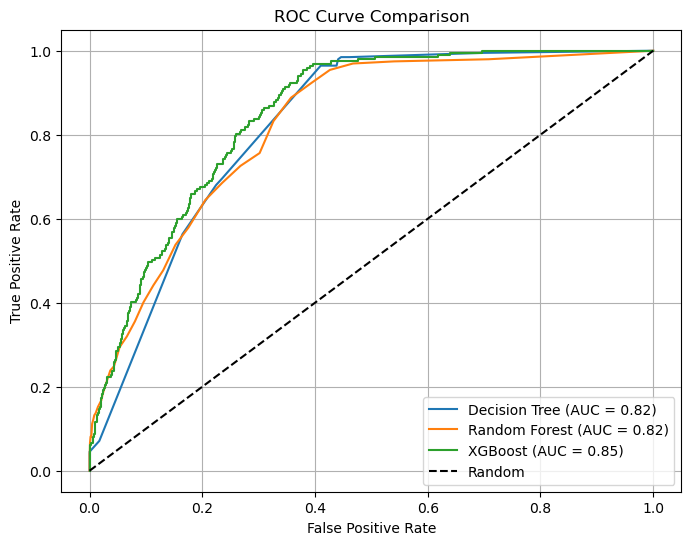

In [12]:
# Set the plot size
plt.figure(figsize=(8,6))

# Plot ROC curve for each model
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]  # Predicted probability of class 1
    fpr, tpr, _ = roc_curve(y_test, y_probs)     # Get false positive rate and true positive rate
    roc_auc = roc_auc_score(y_test, y_probs)     # Calculate AUC score
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")  # Plot ROC curve per model

# Plot reference line for random classifier
plt.plot([0,1], [0,1], 'k--', label='Random')

# Set axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")

# Show legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In the ROC curve comparison, XGBoost achieved the highest AUC (0.85), demonstrating overall superior classification performance.
On the other hand, both Decision Tree and Random Forest had AUC scores of 0.82, which are close but slightly lower than that of XGBoost.

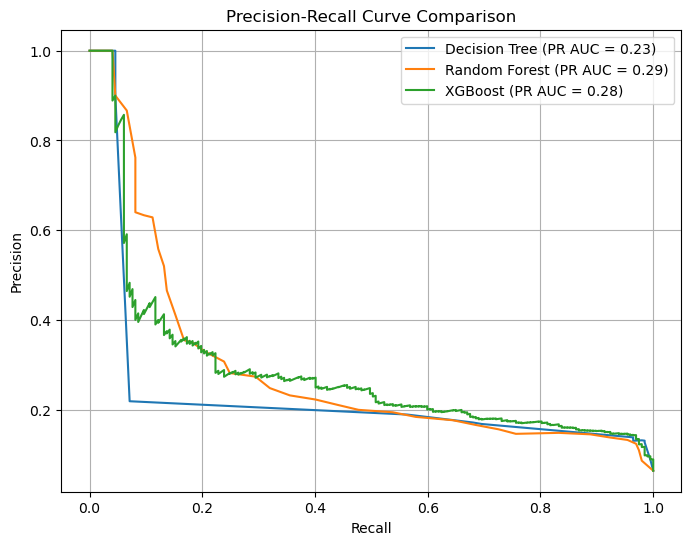

In [13]:
# Set the plot size
plt.figure(figsize=(8,6))

# Plot Precision-Recall (PR) curve for each model
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]  # Predicted probability of class 1
    precision, recall, _ = precision_recall_curve(y_test, y_probs)  # Get precision and recall values
    pr_auc = auc(recall, precision)  # Calculate PR AUC score
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")  # Plot curve for each model

# Set axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")

# Display legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In the PR curve comparison, Random Forest achieved the highest PR AUC (0.29), slightly outperforming XGBoost (0.28).
On the other hand, Decision Tree had the lowest PR AUC (0.23), and precision tended to drop sharply as recall increased.

## 4. Accuracy Improvement Approach
In this chapter, we explore methods to further improve the evaluation metrics obtained from the baseline models.
Specifically, we examine and implement three techniques: feature engineering, oversampling (SMOTE), and threshold tuning.
We compare their effectiveness using XGBoost.

### 4.1 Feature Engineering
In this section, we generate new features based on existing variables and add them to the model.
By doing so, we aim to capture latent relationships not represented in the original data and improve classification performance.

In [14]:
# Create a feature dataset by copying the original data
df_features = df_for_model.copy()

# 1. Calculate the difference in days between accident and claim dates
# Define function to convert categorical variables to numerical values
def days_to_num(x):
    mapping = {
        'none': 0,
        '1 to 7': 4,
        '8 to 15': 12,
        '15 to 30': 22,
        'more than 30': 45
    }
    return mapping.get(x, -1)  # Assign -1 to unknown values

# Add new columns after converting to numeric values
df['Days_Policy_Accident_Num'] = df['Days_Policy_Accident'].map(days_to_num)
df['Days_Policy_Claim_Num'] = df['Days_Policy_Claim'].map(days_to_num)

# Create a new feature representing the difference between claim and accident days
df_features['Days_Diff'] = df['Days_Policy_Claim_Num'] - df['Days_Policy_Accident_Num']

# 2. Determine if the driver is young (1 if under 25)
df_features['Is_YoungDriver'] = (df['Age'] < 25).astype(int)

# Split into features and target variable
X = df_features.drop('FraudFound_P', axis=1)
y = df_features['FraudFound_P']

# Split into training and testing datasets
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost model (with class imbalance adjustment)  
xgb_fe_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale,  # Adjust for class imbalance using sample weights
    random_state=42,
    eval_metric='logloss'
)
xgb_fe_model.fit(X_train_fe, y_train_fe) # Train the model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### 4.2 Oversampling
To mitigate the effects of class imbalance, we applied SMOTE to generate synthetic samples of the minority class and balance the training data.
This approach aims to reduce overfitting and improve the model’s recall.

In [15]:
# Split into features and target variable  
X = df_for_model.drop('FraudFound_P', axis=1)
y = df_for_model['FraudFound_P']

# Split the data into training and test sets  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampling using SMOTE (generate synthetic data for the minority class)  
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the XGBoost model (class weights not needed due to SMOTE)  
xgb_model_smote = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)
xgb_model_smote.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### 4.3 Introduction of Threshold Adjustment
Many classification models adopt a threshold of 0.5 by default, but this is not always optimal.
In this section, we explore an approach to improve model practicality by flexibly setting the threshold according to business needs or evaluation metrics.

In [16]:
# 1. Define and train the model  
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# 2. Get predicted probabilities (probability of belonging to class 1)  
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 3. Calculate F1-score for multiple thresholds  
thresholds = np.arange(0.0, 1.01, 0.01)  # Generate values from 0.00 to 1.00 in 0.01 increments  
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)  # Predicted results based on threshold 
    f1 = f1_score(y_test, y_pred_thresh)        # Compute F1-score
    f1_scores.append(f1)                        # Store the scores

# 4. Get the threshold that yields the best F1-score  
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1-score:", best_threshold)

# 5. Define a custom model class with threshold setting  
class XGBWithThreshold:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):  # Probability prediction method  
        return self.model.predict_proba(X)

    def predict(self, X):  # Prediction method with custom threshold  
        probs = self.model.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

# 6. Save the model with the optimal threshold  
xgb_model_threshold = XGBWithThreshold(xgb_model, best_threshold)

Best threshold for F1-score: 0.05


### 4.4 Model Comparison
In this section, we compare the baseline model with various improved versions of the XGBoost model using different enhancement approaches.
We conduct a comprehensive evaluation based on ROC AUC, PR AUC, F1-score, and Accuracy.

In [17]:
# List of models and their names  
models = [
    ("XGBoost", xgb_model, X_test),                         # Baseline model  
    ("XGBoost_FE", xgb_fe_model, X_test_fe),                # Model with engineered features 
    ("XGBoost_SMOTE", xgb_model_smote, X_test),             # Model with SMOTE applied 
    ("XGBoost_Threshold", xgb_model_threshold, X_test)      # Threshold-adjusted model
]

# List to store evaluation results  
results = []

for name, model, X_eval in models:
    # Get probability predictions (Threshold-adjusted model uses overridden predict method)  
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    y_pred = model.predict(X_eval)

    # Calculate evaluation metrics  
    roc_auc = roc_auc_score(y_test, y_pred_proba)                 # ROC AUC score 
    pr_auc = average_precision_score(y_test, y_pred_proba)        # PR AUC score  
    f1 = f1_score(y_test, y_pred)                                 # F1 score 
    acc = accuracy_score(y_test, y_pred)                          # Accuracy

    # Append results to the list 
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "F1-score": f1,
        "Accuracy": acc
    })

# Output the results as a DataFrame 
results_df = pd.DataFrame(results)
print(results_df)

               Model   ROC AUC    PR AUC  F1-score  Accuracy
0            XGBoost  0.860446  0.289875  0.142857  0.937743
1         XGBoost_FE  0.852922  0.304544  0.273196  0.725681
2      XGBoost_SMOTE  0.847737  0.293285  0.068627  0.938392
3  XGBoost_Threshold  0.860446  0.289875  0.319742  0.794423


As a result of comparing the effects of each accuracy improvement method, there was no significant change in ROC AUC or PR AUC.
However, in terms of F1-score, the threshold-adjusted model (XGBoost_Threshold) showed the highest score.
On the other hand, the SMOTE-applied model had a lower F1-score, indicating that the effect of resampling requires careful evaluation.

## 5. Discussion
In this chapter, we analyze the model's behavior and identify the underlying issues by visualizing feature importance using SHAP values and exploring reasons for performance limitations.

### 5.1 Visualizing Feature Importance with SHAP
To visualize the impact of each feature on the model, we performed feature importance analysis using SHAP values.

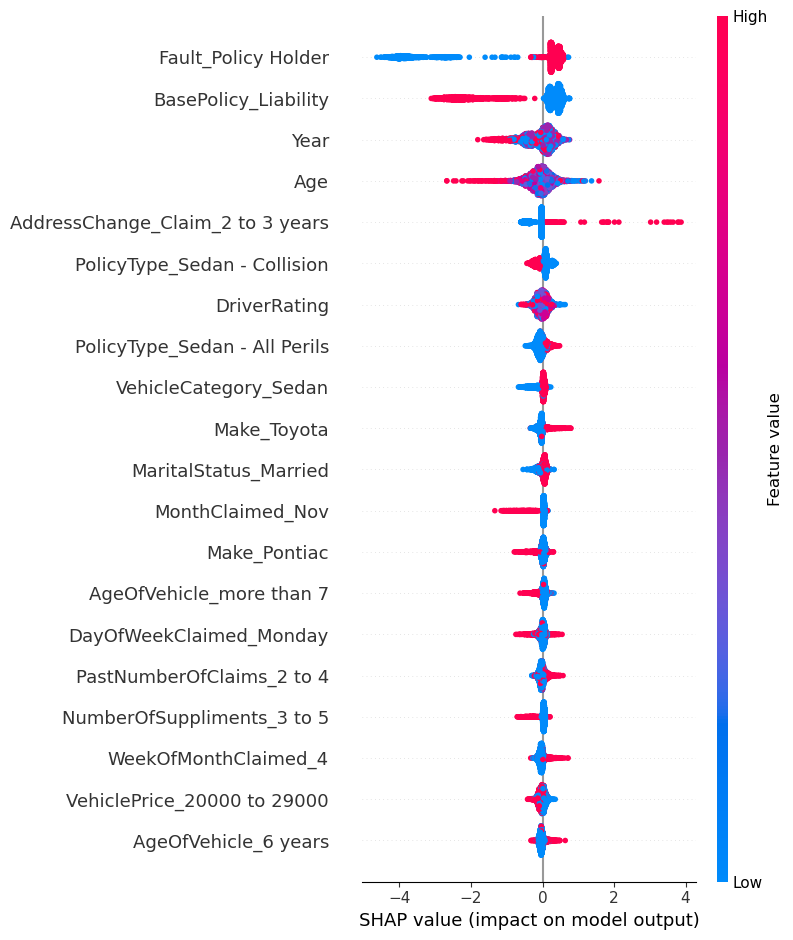

In [18]:
# SHAP explainer for tree-based models like XGBoost  
explainer = shap.TreeExplainer(xgb_model_threshold.model)

# Calculate SHAP values  
shap_values = explainer.shap_values(X_test)

# Display summary plot (global feature importance)  
shap.summary_plot(shap_values, X_test)

### 5.2 Discussion on the Causes of Limited Model Performance

One of the reasons for limited model performance is the impact of class imbalance.
Since fraudulent claims represent only a small portion of the dataset, the model tends to predict the non-fraudulent class more frequently, making it difficult to achieve high F1 scores.
Although we attempted to address this issue using techniques such as SMOTE and threshold adjustment, improvements in PR AUC were limited.
This may be due to the diversity and inconsistency of fraud patterns in the data, insufficient labeling quality, and a lack of information in the feature set itself.
Additionally, the ambiguous or impractical definition of the target variable (fraud) could also introduce noise into the model learning process.

## 6. Conclusion and Business Implications

In this analysis, we built insurance fraud detection models using multiple machine learning algorithms centered on XGBoost.
We compared and evaluated various improvement approaches such as feature engineering, SMOTE, and threshold adjustment based on metrics like precision, recall, PR AUC, and ROC AUC.
While PR AUC and ROC AUC did not show significant changes, the threshold-adjusted model (XGBoost_Threshold) achieved the best performance, with its F1-score improving significantly from 0.14 to 0.32.
This demonstrates that tuning the threshold helped correct the bias toward the non-fraud class and improved the detection capability for fraud cases.
However, fundamental challenges such as class imbalance and the diversity of fraud patterns still constrain overall model accuracy.

From a business perspective, rather than aiming for full automation, it is more practical and effective to use the model as a first-stage filter to support human decision-making.
Additionally, combining the model with other types of data (e.g., geolocation, call history, external data sources) may enable the construction of a more robust fraud detection system.